In [6]:
import os
import random
import numpy as np

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
#     tf.random.set_seed(seed)

seed_everything()

In [7]:
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

# Standard library imports
import glob
import itertools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


from xgboost import XGBRegressor

In [8]:
from catboost import CatBoostRegressor
import lightgbm as LGB

from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso,ElasticNet,Ridge
# from sklearn.svm import SVR

from tqdm import tqdm


# plt.style.available ## find!
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager as fm
import seaborn as sns
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)
font_path = 'c:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
#한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False
#ticks에 적용될 한글 폰트
font_ticks = fm.FontProperties(fname=font_path, size=10)
#title에 적용될 한글 폰트
font_title = fm.FontProperties(fname=font_path, size=13)
pd.set_option('display.max_columns', None)


In [ ]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
# age_gender = pd.read_csv('./data/age_gender_info.csv') : 별도 공간에서 전처리 수행
submission = pd.read_csv('./data/sample_submission.csv')

columns = ['임대건물구분', '지역', '공급유형', '자격유형']
for col in columns:
    complement = list(set(train[col].unique()) - set(test[col].unique()))
    print(f"Train 데이터 기준 차집합 {col} : {complement}")

## 결측치 채우기

In [ ]:
# 임대보증금과 임대료는 '-'을 null로 바꾼 후 float로 타입 변경
train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대보증금=='-', '임대보증금'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
test['임대보증금'] = test['임대보증금'].astype(float)

train.loc[train.임대료=='-', '임대료'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan
train['임대료'] = train['임대료'].astype(float)
test['임대료'] = test['임대료'].astype(float)

In [ ]:
# 임대보증금과 임대료가 NULL인 경우는 상가의 경우 0으로 아파트의 경우 imputation 대체하는 것이 좋아보임
train.loc[(train['임대료'].isnull()) & (train['임대건물구분'] == '상가'), ['임대보증금', '임대료']] = 0
test.loc[(test['임대료'].isnull()) & (test['임대건물구분'] == '상가'), ['임대보증금', '임대료']] = 0

###### test set을 왜 'A'와 'C'로 채우는지에 대한 논리 ######
test[test.단지코드=='C2411'].iloc[:,4:10] # A로 채우면 될듯
test.iloc[196,8] = 'A'

test[test.단지코드=='C2253'].head().iloc[:,4:11] # 임대보증금과 임대료가 존재하는 경우 자격유형이 C => C로 채우면 될듯
test.iloc[258,8] = 'C'

# 임대보증금 임대료 결측치 대체 in train
train[(train['임대건물구분'] != '상가') & (train['임대보증금'].isnull())]
train[(train['지역'] == '대전광역시') & (train['공급유형'] == '공공분양')]
train[train.자격유형=='D'].shape[0]
sum(train[train.자격유형=='D'].임대료.isnull()) # 신분이 D이면 모두 0이였음.
# 대구광역시 지역은 울산 광역시의 C2142지역과 비슷한 면적과 비슷한 임대료를 보임.
train[train.단지코드=='C2142']
train[train.단지코드=='C2186']
train.iloc[2906,9:11] = train.iloc[2898,9:11]
train.iloc[2907,9:11] = train.iloc[2899,9:11]
train.iloc[2908,9:11] = train.iloc[2900,9:11]
train[train.단지코드=='C1786']
train[(train['자격유형'] == 'K') & (train['공급유형'] == '행복주택')]
# 비슷한 전용면적 단지 2개 있는데, 강원도 지역 특성상 더 임대료가 낮은 경상남도 값으로 대체.
train[train.단지코드=='C2245']
train[train.단지코드=='C1156']
train.iloc[2680,9:11] = train.iloc[2815,9:11]
train.iloc[2681,9:11] = train.iloc[2816,9:11]
train.iloc[2682,9:11] = train.iloc[2816,9:11]
train.iloc[2683,9:11] = train.iloc[2816,9:11]
train[train.단지코드=='C1326']
train[(train['자격유형'] == 'H') & (train['공급유형'] == '국민임대') & (train.버스 == 4)]
train[train.단지코드=='C1677']
# 성질이 가장 유사한 값으로 대체.
train.iloc[2547,9:11] = train.iloc[1940,9:11]
train.iloc[2548,9:11] = train.iloc[1940,9:11]
train.iloc[2549,9:11] = train.iloc[1940,9:11]
train.iloc[2550,9:11] = train.iloc[1943,9:11]
train.iloc[2551,9:11] = train.iloc[1947,9:11]

# 임대보증금 임대료 결측치 대체 in train
test[(test['임대건물구분'] != '상가') & (test['임대보증금'].isnull())]
test[test.단지코드=='C1006']
test[test.자격유형=='D'].shape[0]
sum(test[test.자격유형=='D'].임대료.isnull()) # 신분이 D이면 모두 0이였음.
test[test.단지코드=='C2152']
test[(test['자격유형'] == 'C') & (test['공급유형'] == '영구임대') & (test['지역']=='강원도')]
test[test.단지코드=='C2253']
# 가장 유사한 값으로 대체
test.iloc[1005,9:11] = test.iloc[258,9:11]
test.iloc[1006,9:11] = test.iloc[259,9:11]
test[test.단지코드=='C1267']
test[(test['자격유형'] == 'L') & (test['공급유형'] == '행복주택')]
# 행복주택의 경우 부산과 경상남도 큰 차이 미치지 않음.
test.iloc[1014,9:11] = test.iloc[930,9:11]
test.iloc[1015,9:11] = test.iloc[933,9:11]
test.iloc[1016,9:11] = test.iloc[933,9:11]
test.iloc[1017,9:11] = test.iloc[935,9:11]

# 임대보증금과 임대료가 NULL인 경우는 상가의 경우 0으로 아파트의 경우 imputation 대체하는 것이 좋아보임
train[['임대보증금', '임대료']] = train[['임대보증금', '임대료']].fillna(0)
test[['임대보증금', '임대료']] = test[['임대보증금', '임대료']].fillna(0)

train.iloc[2315:2319,12] = 3
sub_dae = list(train[(train.지역=='대전광역시') & train.지하철.isnull()].index)
train.iloc[sub_dae,11] = 1

test[test['지하철'].isnull()]
test[test.지역=='충청남도'].지하철.dropna().value_counts()
# 충남은 0으로 대체.
test[test.지역=='대전광역시'].지하철.dropna().value_counts()
test[test.지역=='대전광역시'].groupby(['단지코드']).max().지하철.dropna().value_counts()
# train data에서 1:10 vs 0:7이였는데, 합산해서 계산해보면, 1로 대체하는 것이 좋아보임.
sub_dae = list(test[(test.지역=='대전광역시') & test.지하철.isnull()].index)
test.iloc[sub_dae,11] = 1

cols = ['지하철', '버스']
train[cols] = train[cols].fillna(0)
test[cols] = test[cols].fillna(0)

## 외부 데이터 처리

In [ ]:

#################################

age_gender = pd.read_csv('./data/age_gender_info.csv')

# outer_1 = pd.read_csv('./data/자동차보유대수별_가구_가구주의_행정구역_성_연령별__20210716014801.csv', encoding='cp949', skiprows=[0]) # 2005 자료
# outer_3 = pd.read_csv('./data/자동차등록대수현황_시도별_20210710221119.csv', encoding='cp949', skiprows=[0]) : outer_1과 같은 정보

outer_1 = pd.read_excel('./data/자동차등록현황보고 (Total Registered Moter Vehicles).xlsx', header=None) ## 2020
outer_2 = pd.read_csv('./data/1인당_자동차_등록대수_시도_시_군_구__20210710220856.csv', encoding='cp949', skiprows=[0]) ## 2020
outer_3 = pd.read_excel('./data/개별공시지가_주요_통계(2011-2020).xlsx', sheet_name = '개별지 평균가격') ## 2020
outer_4 = pd.read_excel('./data/개별공시지가_주요_통계(2011-2020).xlsx', sheet_name = '개별지 전국평균가격 대비 배율') ## 2020
outer_5 = pd.read_csv('./data/시도별_1인당_지역내총생산__지역총소득__개인소득_20210716001511.csv', encoding='cp949', skiprows=[0]) ## 2019
outer_6 = pd.read_excel('./data/지역별 인구 및 인구밀도.xls', skiprows=[0,1], thousands=',') # 2020

# 승용차 등록 현황 (2020.12)
outer_1.columns = ['지역','시군구','자가용','영업용']
outer_1.drop('시군구', axis=1, inplace = True)
outer_1 = outer_1.loc[outer_1['지역'] != '인천']

# 1인당 자동차 등록 대수 (2020)
outer_2.drop([outer_2.columns[2], outer_2.columns[3]], axis=1, inplace=True)
outer_2.drop(index=0, inplace=True) # 총계에 해당하는 인덱스 삭제
outer_2.columns = ['지역', '1인당 자동차등록대수']
outer_2 = outer_2.loc[outer_2['지역'] != '인천광역시']

# '개별지 평균가격'
outer_3 = outer_3.loc[:, ['구 분','2020년']]
outer_3.drop(index=0, inplace=True) 
outer_3.columns = ['지역', '개별지_평균가격']
outer_3.drop(index=4, inplace=True) # 인천에 해당하는 인덱스 삭제

# '개별지 전국평균가격 대비 배율'
outer_4.head()
outer_4 = outer_4.loc[:, ['구 분','2020년']]
outer_4.drop(index=0, inplace=True)
outer_4.columns = ['지역', '개별지_전국평균가격대비배율']
outer_4.drop(index=4, inplace=True) # 인천에 해당하는 인덱스 삭제

# 소비 지표
outer_5=outer_5.rename(columns = {'시도별':'지역'})
outer_5 = outer_5.loc[outer_5['지역'] != '인천광역시']

# 인구, 인구밀도
outer_6 = outer_6.iloc[:, [0,9,10]]
outer_6.columns = ['지역','인구','인구밀도']
outer_6.drop(index=[0,1,19,20,21,22,23], inplace=True)
outer_6.reset_index(inplace=True)
outer_6.drop('index', axis=1, inplace = True)
outer_6 = outer_6.loc[outer_6['지역'] != '인천']

## 지역의 값이 일치하도록 만들어줌
region_list = list(np.sort(age_gender['지역'].unique()))

outer_1_list = list(np.sort(outer_1['지역'].unique()))
outer_3_list = list(np.sort(outer_3['지역'].unique()))
outer_4_list = list(np.sort(outer_4['지역'].unique()))
outer_6_list = list(np.sort(outer_6['지역'].unique()))

for a, b in zip(region_list, outer_1_list):
    outer_1['지역'] = outer_1['지역'].replace(b, a)

for a, b in zip(region_list, outer_3_list):
    outer_3['지역'] = outer_3['지역'].replace(b, a)

for a, b in zip(region_list, outer_4_list):
    outer_4['지역'] = outer_4['지역'].replace(b, a)    
    
for a, b in zip(region_list, outer_6_list):
    outer_6['지역'] = outer_6['지역'].replace(b, a)   
    
# 외부 데이터 병합
merge_outer = pd.merge(outer_1, outer_2, on = '지역')
merge_outer = pd.merge(merge_outer, outer_3, on = '지역')
merge_outer = pd.merge(merge_outer, outer_4, on = '지역')
merge_outer = pd.merge(merge_outer, outer_5, on = '지역')
merge_outer = pd.merge(merge_outer, outer_6, on = '지역')

# setting ageband
age_gender["no_car_women"] = age_gender.iloc[:,1] + age_gender.iloc[:,3]
age_gender["no_car_men"] = age_gender.iloc[:,2] + age_gender.iloc[:,4]
age_gender["social_women"] = age_gender.iloc[:,5] + age_gender.iloc[:,7] + age_gender.iloc[:,9] + age_gender.iloc[:,11]
age_gender["social_men"] = age_gender.iloc[:,6] + age_gender.iloc[:,8] + age_gender.iloc[:,10] + age_gender.iloc[:,12]
age_gender["grand_mother"] = age_gender.iloc[:,13] + age_gender.iloc[:,15] + age_gender.iloc[:,17] + age_gender.iloc[:,19] + age_gender.iloc[:,21]
age_gender["grand_father"] = age_gender.iloc[:,14] + age_gender.iloc[:,16] + age_gender.iloc[:,18] + age_gender.iloc[:,20] + age_gender.iloc[:,22]

age_gender.drop(['10대미만(여자)', '10대미만(남자)', '10대(여자)', '10대(남자)', '20대(여자)',
                 '20대(남자)', '30대(여자)', '30대(남자)', '40대(여자)', '40대(남자)', '50대(여자)',
                 '50대(남자)', '60대(여자)', '60대(남자)', '70대(여자)', '70대(남자)', '80대(여자)',
                 '80대(남자)', '90대(여자)', '90대(남자)', '100대(여자)', '100대(남자)'], axis=1, inplace=True)

# 외부 데이터와 age_gender 데이터 병합
age_gender = pd.merge(merge_outer, age_gender, on = '지역')

# 인구와 인구밀도의 자료형을 object에서 float로 변경시키기
# age_gender['인구'] = age_gender['인구'].astype('float')
# age_gender['인구밀도'] = age_gender['인구밀도'].astype('float')

# age_gender['1인당 소비비율'] = age_gender['1인당 민간소비'] / age_gender['1인당 개인소득']
# age_gender['1인당 생산 대비 소득비율'] = age_gender['1인당 지역총소득'] / age_gender['1인당 지역내총생산']
# age_gender['자가용 비율'] = age_gender['자가용'] / ( age_gender['자가용'] + age_gender['영업용'] )
# age_gender['region_density'] =  age_gender['인구밀도'] / age_gender['인구']

## 각 계층에 인구수 반영해보기

# age_gender['no_car_women'] = age_gender["no_car_men"] * age_gender['인구']
# age_gender["no_car_men"] = age_gender["no_car_men"] * age_gender['인구']
# age_gender["social_women"] = age_gender["social_women"] * age_gender['인구']
# age_gender["social_men"] = age_gender["social_men"] * age_gender['인구']
# age_gender["grand_mother"] = age_gender["grand_mother"] * age_gender['인구']
# age_gender["grand_father"] = age_gender["grand_father"] * age_gender['인구']

## 살린 변수들 : 1인당 개인소득
age_gender.drop(['자가용', '영업용', '개별지_평균가격', '개별지_전국평균가격대비배율',
                 '1인당 지역내총생산', '1인당 지역총소득', '1인당 민간소비', '인구', '인구밀도',
                 '1인당 자동차등록대수'], axis=1, inplace=True)

#####################

## 단지 당 요약 수치를 추출해서 적합 데이터로 사용

In [ ]:
## baseline
# train['전용면적'] = train['전용면적'] // 10 * 10
# train['전용면적'] = np.where(train['전용면적'] > 100, 100, train['전용면적'])
# train['전용면적'] = np.where(train['전용면적'] < 15, 15, train['전용면적'])

# test['전용면적'] = test['전용면적'] // 10 * 10
# test['전용면적'] = np.where(test['전용면적'] > 100, 100, test['전용면적'])
# test['전용면적'] = np.where(test['전용면적'] < 15, 15, test['전용면적'])

## quantile cut -> 다시 시도해볼만한 가치가 있는 거 같음
train['전용면적'] = pd.qcut(train['전용면적'], [0,.25,.3,.75,1]).cat.codes
test['전용면적'] = pd.qcut(test['전용면적'], [0,.25,.3,.75,1]).cat.codes

unique_cols = ['총세대수', '지역', '공가수', '지하철', '버스', '단지내주차면수', '등록차량수',
               '전용면적', '전용면적별세대수', '임대보증금', '임대료', '단지코드']
train_agg = train[unique_cols].drop_duplicates()
test_agg = test[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()

# train_agg.loc[:,'총전용면적'] = train_agg.loc[:,'전용면적'] * train_agg.loc[:,'전용면적별세대수']

codes = train_agg.단지코드.unique()
areas = np.sort(train_agg.전용면적.unique())

train_edited = pd.DataFrame()
columns = ['단지코드', '등록차량수', '총세대수', '지역', '공가수','지하철', '버스', '단지내주차면수']

for order, code in enumerate(codes):
    temp_by_code = train.loc[train.단지코드==code].reset_index(drop=True)
    ## 원 계열 값 그냥 가져오기
    train_edited.loc[order, columns] = temp_by_code.loc[0, columns]
    train_edited.loc[order, "총임대가구수"] = temp_by_code.전용면적별세대수.sum()
    train_edited.loc[order, '세대당 임대보증금'] = (temp_by_code['임대보증금'] * temp_by_code['전용면적별세대수']).sum() / train_edited.loc[order, "총임대가구수"]
    train_edited.loc[order, '세대당 임대료'] = (temp_by_code['임대료'] * temp_by_code['전용면적별세대수']).sum() / train_edited.loc[order, "총임대가구수"]
    train_edited.loc[order, '세대당 면적'] = (temp_by_code['전용면적'] * temp_by_code['전용면적별세대수']).sum() / train_edited.loc[order, "총임대가구수"]

    for area in areas:
        temp_by_code_areas = temp_by_code.loc[temp_by_code.전용면적==area].reset_index(drop=True)

        if temp_by_code_areas.shape[0] != 0:
#             train_edited.loc[order, f'면적_{int(area)}'] = temp_by_code_areas.전용면적별세대수.sum() / temp_by_code_areas.총세대수[0]
            train_edited.loc[order, f'면적_{int(area)}'] = temp_by_code_areas.전용면적별세대수.sum() / train_edited.loc[order, "총임대가구수"]

        else:
            train_edited.loc[order, f'면적_{int(area)}'] = 0


train_edited["임대비율"] = train_edited.총임대가구수 / train_edited.총세대수
# train_edited["상가비율"] = 1 - train_edited.총임대가구수 / train_edited.총세대수

train_edited["가구당주차면수"] = train_edited.단지내주차면수 / train_edited.총세대수

## gender 정보 병합
train_edited = pd.merge(train_edited, age_gender, left_on= ["지역"], right_on= ["지역"], how='left')


# test_agg.loc[:,'총전용면적'] = test_agg.loc[:,'전용면적'] * test_agg.loc[:,'전용면적별세대수']

codes = test_agg.단지코드.unique()
areas = np.sort(test.전용면적.unique())

test_edited = pd.DataFrame()
columns = ['단지코드', '총세대수', '지역', '공가수', '지하철', '버스', '단지내주차면수']

for order, code in enumerate(codes):
    temp_by_code = test.loc[test.단지코드==code].reset_index(drop=True)
    ## 원 계열 값 그냥 가져오기
    test_edited.loc[order, columns] = temp_by_code.loc[0, columns]
    test_edited.loc[order, "총임대가구수"] = temp_by_code.전용면적별세대수.sum()    
    test_edited.loc[order, '세대당 임대보증금'] = (temp_by_code['임대보증금'] * temp_by_code['전용면적별세대수']).sum() / test_edited.loc[order, "총임대가구수"]
    test_edited.loc[order, '세대당 임대료'] = (temp_by_code['임대료'] * temp_by_code['전용면적별세대수']).sum() / test_edited.loc[order, "총임대가구수"]
    test_edited.loc[order, '세대당 면적'] = (temp_by_code['전용면적'] * temp_by_code['전용면적별세대수']).sum() / test_edited.loc[order, "총임대가구수"]

    for area in areas:
        temp_by_code_areas = temp_by_code.loc[temp_by_code.전용면적==area].reset_index(drop=True)

        if temp_by_code_areas.shape[0] !=0:
#             test_edited.loc[order, f'면적_{int(area)}'] = temp_by_code_areas.전용면적별세대수.sum() / temp_by_code_areas.총세대수[0]
            test_edited.loc[order, f'면적_{int(area)}'] = temp_by_code_areas.전용면적별세대수.sum() / test_edited.loc[order, "총임대가구수"]
        else:
            test_edited.loc[order, f'면적_{int(area)}'] = 0


test_edited["임대비율"] = test_edited.총임대가구수 / test_edited.총세대수
# test_edited["상가비율"] = 1 - test_edited.총임대가구수 / test_edited.총세대수

test_edited["가구당주차면수"] = test_edited.단지내주차면수 / test_edited.총세대수

## gender 정보 병합
test_edited = pd.merge(test_edited, age_gender, left_on= ["지역"], right_on= ["지역"], how='left')


#####

train_edited['주차면수대비총세대수비율'] = train_edited['총세대수'] / train_edited['단지내주차면수']
train_edited['거주율'] = 1 - (train_edited['공가수'] / train_edited['총세대수'])

train_edited['거주율95%이상'] = train_edited['거주율'].apply(lambda x: 1 if x>=0.95 else 0)

test_edited['주차면수대비총세대수비율'] = test_edited['총세대수'] / test_edited['단지내주차면수']
test_edited['거주율'] = 1 - (test_edited['공가수'] / test_edited['총세대수'])

test_edited['거주율95%이상'] = test_edited['거주율'].apply(lambda x: 1 if x>=0.95 else 0)

### CATBOOST 데이터 형식으로 만들어주기

In [ ]:
def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+col for col in res.columns})
    return res

train.loc[train.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
train.loc[train.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'
test.loc[test.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'

train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

train.loc[train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
test.loc[test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'

train.loc[train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'

train_agg = pd.concat([train_edited.set_index('단지코드'), # 파생변수 생성을 위해 단지코드가 변수에 있었음
                       reshape_cat_features(data=train, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='자격유형', value_col='counter')], axis=1)

test_agg = pd.concat([test_edited.set_index('단지코드'),
                       reshape_cat_features(data=test, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='자격유형', value_col='counter')], axis=1)


# 지역 encoding

train_region_list = train_agg.지역.unique()
train_mapping_list = list(range(0,16,1))

for a, b in zip(train_region_list, train_mapping_list):
    train_agg['지역'] = train_agg['지역'].replace(a, b)

for a, b in zip(train_region_list, train_mapping_list):
    test_agg['지역'] = test_agg['지역'].replace(a, b)

train_agg['지역'] = train_agg['지역'].astype('category')
test_agg['지역'] = test_agg['지역'].astype('category')

# 파생변수를 만든 변수들 제거해보기 : '공가수', '총임대가구수', '거주율95%이상'
train_agg.drop(['임대건물구분_아파트'], axis=1, inplace=True)
test_agg.drop(['임대건물구분_아파트'], axis=1, inplace=True)

train_agg = train_agg.drop(['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988', # 데이콘 공식 오류 3번 사항
                            'C1036', 'C2085', 'C1397', 'C2431', 'C1649', # 데이콘 공식 오류 2번 사항   
                            'C1032', 'C1005', 'C2612', 'C1363'], axis=0) # train 적합을 통한 이상치 판단




## MEAN ENCODING

In [145]:
## train과 test에 똑같이 존재하는 case

encoding_features = ['거주율95%이상', '임대건물구분_상가', '지하철']

for feature in encoding_features:
    
    car_by_mean = pd.pivot_table(train_agg, values = '등록차량수', index = [feature], aggfunc = np.mean).reset_index()
    car_by_median = pd.pivot_table(train_agg, values = '등록차량수', index = [feature], aggfunc = np.median).reset_index()
    
    tqdm.pandas()
    
    train_agg[feature+'_mean'] = train_agg.progress_apply(lambda x : car_by_mean.loc[(car_by_mean[feature] == x[feature]) ,'등록차량수'].values[0], axis = 1)
    train_agg[feature+'_median'] = train_agg.progress_apply(lambda x : car_by_median.loc[(car_by_median[feature] == x[feature]) ,'등록차량수'].values[0], axis = 1)
    
    test_agg[feature+'_mean'] = test_agg.progress_apply(lambda x : car_by_mean.loc[(car_by_mean[feature] == x[feature]) ,'등록차량수'].values[0], axis = 1)
    test_agg[feature+'_median'] = test_agg.progress_apply(lambda x : car_by_median.loc[(car_by_median[feature] == x[feature]) ,'등록차량수'].values[0], axis = 1)

100%|██████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 3340.58it/s]


In [146]:
## train과 test의 범주가 다른 case

#######################################
## 아파트 정보별 등록차량수 평균 넣어주기
#######################################

car_by_apt_mean = pd.pivot_table(train_agg, values = '등록차량수', index = ['info_apart'], aggfunc = np.mean).reset_index()
car_by_apt_median = pd.pivot_table(train_agg, values = '등록차량수', index = ['info_apart'], aggfunc = np.median).reset_index()

tqdm.pandas()

train_agg['car_apt_mean'] = train_agg.progress_apply(lambda x : car_by_apt_mean.loc[(car_by_apt_mean['info_apart'] == x['info_apart']) ,'등록차량수'].values[0], axis = 1)
train_agg['car_apt_median'] = train_agg.progress_apply(lambda x : car_by_apt_median.loc[(car_by_apt_median['info_apart'] == x['info_apart']) ,'등록차량수'].values[0], axis = 1)

def impute_apt_mean(x):
    if sum(car_by_apt_mean['info_apart'] == x) == 1:
        v = car_by_apt_mean.loc[(car_by_apt_mean['info_apart'] == x) ,'등록차량수'].values[0]
    else:
        v = np.mean(train_agg['등록차량수'])
    return v

def impute_apt_median(x):
    if sum(car_by_apt_median['info_apart'] == x) == 1:
        v = car_by_apt_median.loc[(car_by_apt_median['info_apart'] == x) ,'등록차량수'].values[0]
    else:
        v = np.median(train_agg['등록차량수'])
    return v

test_agg['car_apt_mean'] = test_agg['info_apart'].apply(impute_apt_mean)
test_agg['car_apt_median'] = test_agg['info_apart'].apply(impute_apt_median)

#######################################
## 지하철 값별 등록차량수 평균 넣어주기
#######################################

# car_by_sub_mean = pd.pivot_table(train_agg, values = '등록차량수', index = ['지하철'], aggfunc = np.mean).reset_index()
# tqdm.pandas()
# train_agg['car_sub_mean'] = train_agg.progress_apply(lambda x : car_by_sub_mean.loc[(car_by_sub_mean['지하철'] == x['지하철']) ,'등록차량수'].values[0], axis = 1)
# test_agg['car_sub_mean'] = test_agg.progress_apply(lambda x : car_by_sub_mean.loc[(car_by_sub_mean['지하철'] == x['지하철']) ,'등록차량수'].values[0], axis = 1)

#######################################
## 버스 값별 등록차량수 평균 넣어주기
#######################################

car_by_bus_mean = pd.pivot_table(train_agg, values = '등록차량수', index = ['버스'], aggfunc = np.mean).reset_index()
car_by_bus_median = pd.pivot_table(train_agg, values = '등록차량수', index = ['버스'], aggfunc = np.median).reset_index()

tqdm.pandas()

train_agg['car_bus_mean'] = train_agg.progress_apply(lambda x : car_by_bus_mean.loc[(car_by_bus_mean['버스'] == x['버스']) ,'등록차량수'].values[0], axis = 1)
train_agg['car_bus_median'] = train_agg.progress_apply(lambda x : car_by_bus_median.loc[(car_by_bus_median['버스'] == x['버스']) ,'등록차량수'].values[0], axis = 1)

def impute_bus_mean(x):
    if sum(car_by_bus_mean['버스'] == x) == 1:
        v = car_by_bus_mean.loc[(car_by_bus_mean['버스'] == x) ,'등록차량수'].values[0]
    else:
        v = np.mean(train_agg['등록차량수'])
    return v

def impute_bus_median(x):
    if sum(car_by_bus_median['버스'] == x) == 1:
        v = car_by_bus_median.loc[(car_by_bus_median['버스'] == x) ,'등록차량수'].values[0]
    else:
        v = np.median(train_agg['등록차량수'])
    return v


test_agg['car_bus_mean'] = test_agg['버스'].apply(impute_bus_mean)
test_agg['car_bus_median'] = test_agg['버스'].apply(impute_bus_median)



100%|██████████████████████████████████████████████████████████████████████████████| 407/407 [00:00<00:00, 3488.37it/s]


## PYCARET MODEL / get best models, tuning

In [193]:
from pycaret.regression import *

train = train_agg.copy()
test = test_agg.copy()

In [ ]:
random.seed(42)

In [239]:
categorical_list = ['지역', '거주율95%이상',
#                     '면적_1', '면적_2', '면적_3',
                    '면적_0', '면적_1', '면적_2', '면적_3', ## qcut!
#                     '면적_15', '면적_20', '면적_30', '면적_40', '면적_50', '면적_60', '면적_70', '면적_80', '면적_100',
                    'info_apart',
                    '임대건물구분_상가', 
                    '공급유형_공공임대(50년)', '공급유형_공공임대(5년/10년/분납/분양)', '공급유형_국민임대/장기전세',
                    '공급유형_영구임대', '공급유형_임대상가', '공급유형_행복주택',
                    '자격유형_A', '자격유형_D', '자격유형_국민임대/장기전세_공급대상',
                    '자격유형_영구임대_공급대상', '자격유형_행복주택_공급대상']

numerical_list = [column for column in train_agg.columns if column not in categorical_list]

reg = setup(data = train, target = '등록차량수',
            train_size=0.8, fold = 5,
            categorical_features = categorical_list,
            numeric_features = numerical_list,
            session_id = 42, use_gpu=True,
            preprocess = True,
#             imputation_type = 'iterative',
            normalize = True, normalize_method = 'robust',
            transformation = True, transformation_method = 'quantile',
            transform_target = True, transform_target_method = 'box-cox',
            remove_outliers = True, outliers_threshold = 0.03,
#             remove_multicollinearity = True, multicollinearity_threshold = 0.9,
#             feature_selection = True, feature_selection_threshold = 0.3, feature_selection_method = 'boruta',
#             create_clusters = True, cluster_iter = 12,
            n_jobs = -1, # for tuner
            silent=True)

,Description,Value
0,session_id,42
1,Target,등록차량수
2,Original Data,"(407, 55)"
3,Missing Values,False
4,Numeric Features,25
5,Categorical Features,29
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(315, 306)"


In [ ]:
## 파이프라인 빼내려면,

# help(get_config)

# prep_pipe = get_config(variable='prep_pipe')
# prep_train = prep_pipe.fit_transform(train)
# prep_test = prep_pipe.transform(test) ############ 여기서는 그냥 데이터 내보내는건데 fit_transform 아닐까..? 

# prep_train.to_csv('./data/prep_train.csv')
# prep_test.to_csv('./data/prep_test.csv')

In [240]:
## different metric!!
from sklearn.metrics import median_absolute_error ##이거로도 최적화 해보기
from sklearn.metrics import make_scorer

def median_AE(y, y_pred):
    return median_absolute_error(y, y_pred)

def MPE(y_test, y_pred): 
	return np.mean((y_test - y_pred) / y_test) * 100

try:
    add_metric(id="my_medae_metric", name="my_MEDAE_metric", score_func=median_AE, greater_is_better = False)
    add_metric(id="my_mpe_metric", name="my_MPE_metric", score_func=MPE)
except:
    print('fail T.T')

best_3 = compare_models(sort = 'MAE', n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,my_MEDAE_metric,my_MPE_metric,TT (Sec)
catboost,CatBoost Regressor,105.3987,24577.1505,156.3385,0.8051,0.3816,0.3435,73.8150,-18.2813,2.5900
et,Extra Trees Regressor,113.3711,27654.8877,165.8532,0.7805,0.3558,0.3160,73.7963,-15.4950,0.5720
gbr,Gradient Boosting Regressor,113.6513,27524.4692,165.4703,0.7817,0.3598,0.3169,80.9501,-13.7669,0.1660
lightgbm,Light Gradient Boosting Machine,115.2375,29003.8097,169.8538,0.7695,0.3857,0.3426,79.9235,-16.0437,0.5240
rf,Random Forest Regressor,117.9924,29847.2102,172.3356,0.7631,0.3650,0.3239,80.3163,-14.8178,0.6360
ada,AdaBoost Regressor,126.0912,33805.8182,183.6331,0.7305,0.4063,0.3704,87.9899,-16.7649,0.1480
xgboost,Extreme Gradient Boosting,126.4599,36256.4262,189.9263,0.7088,0.3811,0.3343,79.4130,-12.9069,0.6760
dt,Decision Tree Regressor,157.6730,50349.7619,223.2768,0.5963,0.4463,0.3918,113.4000,-14.6463,0.0220
knn,K Neighbors Regressor,175.7090,54526.9373,232.1646,0.5708,0.5930,0.7254,139.2176,-50.2806,0.0520
en,Elastic Net,211.5747,84855.7359,290.4976,0.3290,0.6726,0.8740,164.0378,-60.8978,0.0180


,MAE,MSE,RMSE,R2,RMSLE,MAPE,my_MEDAE_metric,my_MPE_metric
0,94.4073,23922.0955,154.6677,0.7940,0.3538,0.2817,55.7317,-9.3683
1,119.3236,25335.4174,159.1710,0.7999,0.5327,0.5893,106.0337,-40.6046
2,104.2616,26941.1245,164.1375,0.7887,0.2952,0.2043,59.2877,-3.7402
3,111.9642,28550.0999,168.9677,0.7813,0.3437,0.2844,73.6379,-12.7174
4,109.1201,21087.4488,145.2152,0.8033,0.3895,0.3390,96.5909,-16.0736
Mean,107.8154,25167.2372,158.4318,0.7935,0.3830,0.3397,78.2564,-16.5008
SD,8.2917,2561.7874,8.1603,0.0079,0.0807,0.1319,19.9812,12.7216


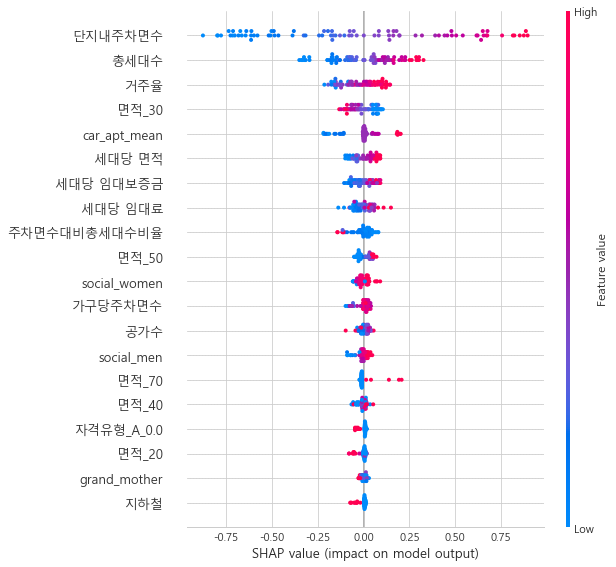

In [72]:
random.seed(42)
cat = create_model('catboost', cross_validation = True)
interpret_model(cat)

In [ ]:
## random search tuning

from ray import tune
import ray
random.seed(42)

In [ ]:
et = create_model('et', cross_validation = True)
cat = create_model('catboost', cross_validation = True)
gbr = create_model('gbr', cross_validation = True)

ray.init(num_cpus = 1)
tuned_et = tune_model(et,
                      search_library = "tune-sklearn", search_algorithm="optuna",
                      tuner_verbose = 2,
                      optimize = 'MAE',
                      early_stopping = True, choose_better = True, n_iter = 100)
ray.shutdown()

ray.init()
tuned_cat = tune_model(cat,
                       search_library = "tune-sklearn", search_algorithm="optuna",
                       tuner_verbose = 2,
                       optimize = 'MAE',
                       early_stopping = True, choose_better = True, n_iter = 100)
  
ray.shutdown()

ray.init()

gbr = create_model('gbr', cross_validation = True)
tuned_gbr = tune_model(gbr,
                       search_library = "tune-sklearn", search_algorithm="optuna",
                       tuner_verbose = 2,
                       optimize = 'MAE',
                       early_stopping = True, choose_better = True, n_iter = 50)

ray.shutdown()


## BLENDING best Models

In [ ]:
random.seed(42)
blender_specific = blend_models([tuned_cat, tuned_et, tuned_gbr], optimize = 'MAE', choose_better = True, weights=None)

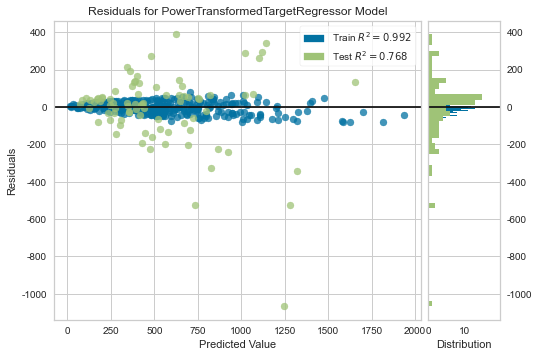

In [258]:
plot_model(blender_specific)

## Predict parking space need of specific apartment

In [265]:
random.seed(42)
# 마지막 학습(Finalize)
final_model = finalize_model(blender_specific)
# 예측(Predict)
pred = predict_model(final_model, data = test)

sub = pred.Label.reset_index()
sub.rename(columns = {'index' : 'code', "Label" : "num"}, inplace=True)

In [267]:
sub

,code,num
0,C1072,708.140110
1,C1128,1142.898675
2,C1456,518.397704
3,C1840,531.318630
4,C1332,1230.174629
...,...,...
145,C2456,262.173142
146,C1266,417.641699
147,C2152,24.292860
148,C1267,400.188545


In [270]:
sub.to_csv('./sub/auto__ens.csv', index = False)